In [2]:
import json
from itertools import islice
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator


from gluonts.core import serde
from gluonts.dataset.artificial import recipe as rcp

/Users/nhassen/opt/anaconda3/envs/CWP-assignment/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
# plotting utils


def plot_recipe(recipe, length):
    output_dict = rcp.evaluate(recipe, length)
    K = len(output_dict)
    lct = MultipleLocator(288)
    minor = AutoMinorLocator(12)

    fig, axs = plt.subplots(K, 1, figsize=(16, 2 * len(recipe)))
    for i, k in enumerate(output_dict):
        axs[i].xaxis.set_major_locator(lct)
        axs[i].xaxis.set_minor_locator(minor)
        axs[i].plot(output_dict[k])
        axs[i].grid()
        axs[i].set_ylabel(k)


def plot_examples(target, length, num, anomaly_indicator=None):
    fix, axs = plt.subplots(num, 1, figsize=(16, num * 2))
    for i in range(num):
        xx = rcp.evaluate(
            dict(target=target, anomaly_indicator=anomaly_indicator), length
        )
        axs[i].plot(xx["target"])
        axs[i].set_ylim(0, 1.1 * np.max(xx["target"]))
        axs[i].grid()
        if anomaly_indicator is not None:
            axs[i].fill_between(
                np.arange(len(xx["target"])),
                xx["anomaly_indicator"] * 1.1 * np.max(xx["target"]),
                np.zeros(len(xx["target"])),
                alpha=0.3,
                color="red",
            )


def print_dicts(*dicts):
    for d in dicts:
        print("{")
        for k, v in d.items():
            print("\t", k, ": ", v)
        print("}\n")

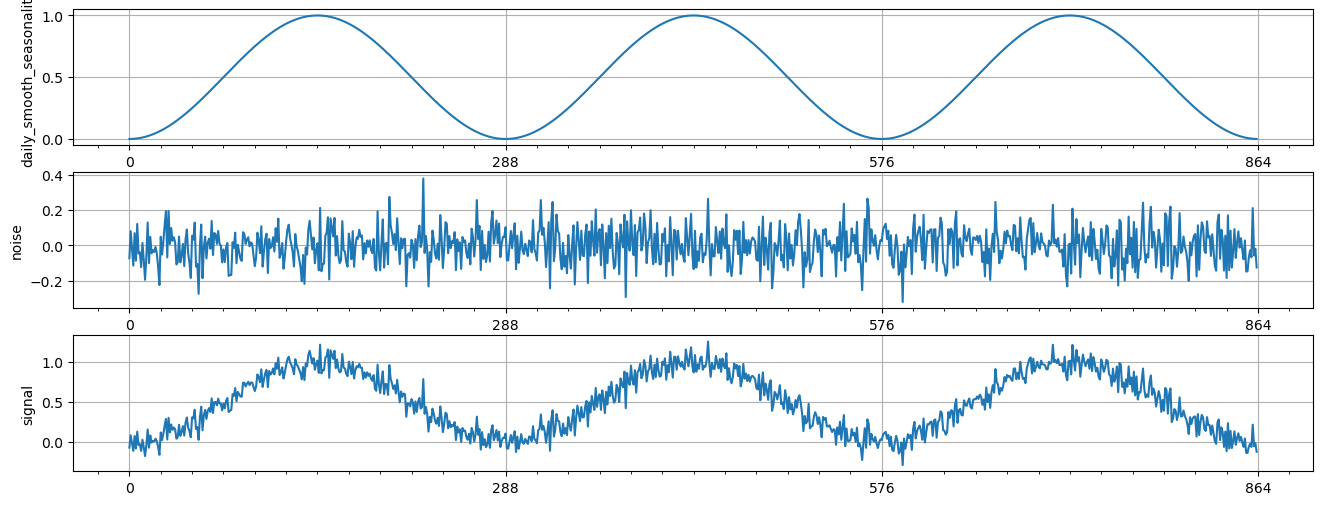

In [4]:

daily_smooth_seasonality = rcp.SmoothSeasonality(period=288, phase=-72)
noise = rcp.RandomGaussian(stddev=0.1)
signal = daily_smooth_seasonality + noise

recipe = dict(
    daily_smooth_seasonality=daily_smooth_seasonality, noise=noise, signal=signal
)

plot_recipe(recipe, 3 * 288)

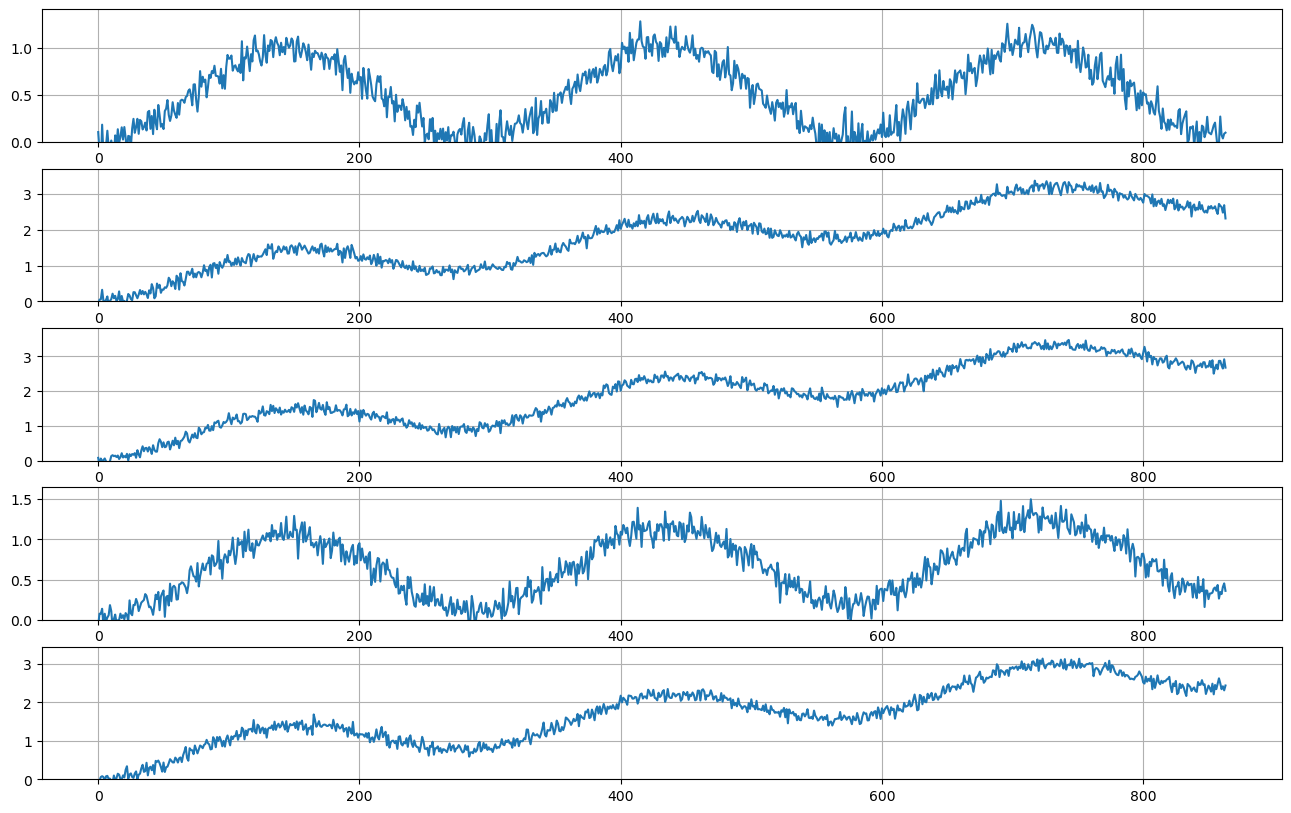

In [5]:
slope = rcp.RandomUniform(low=0, high=3, shape=(1,))
trend = rcp.LinearTrend(slope=slope)
daily_smooth_seasonality = rcp.SmoothSeasonality(period=288, phase=-72)
noise = rcp.RandomGaussian(stddev=0.1)
signal = trend + daily_smooth_seasonality + noise

plot_examples(signal, 3 * 288, 5)

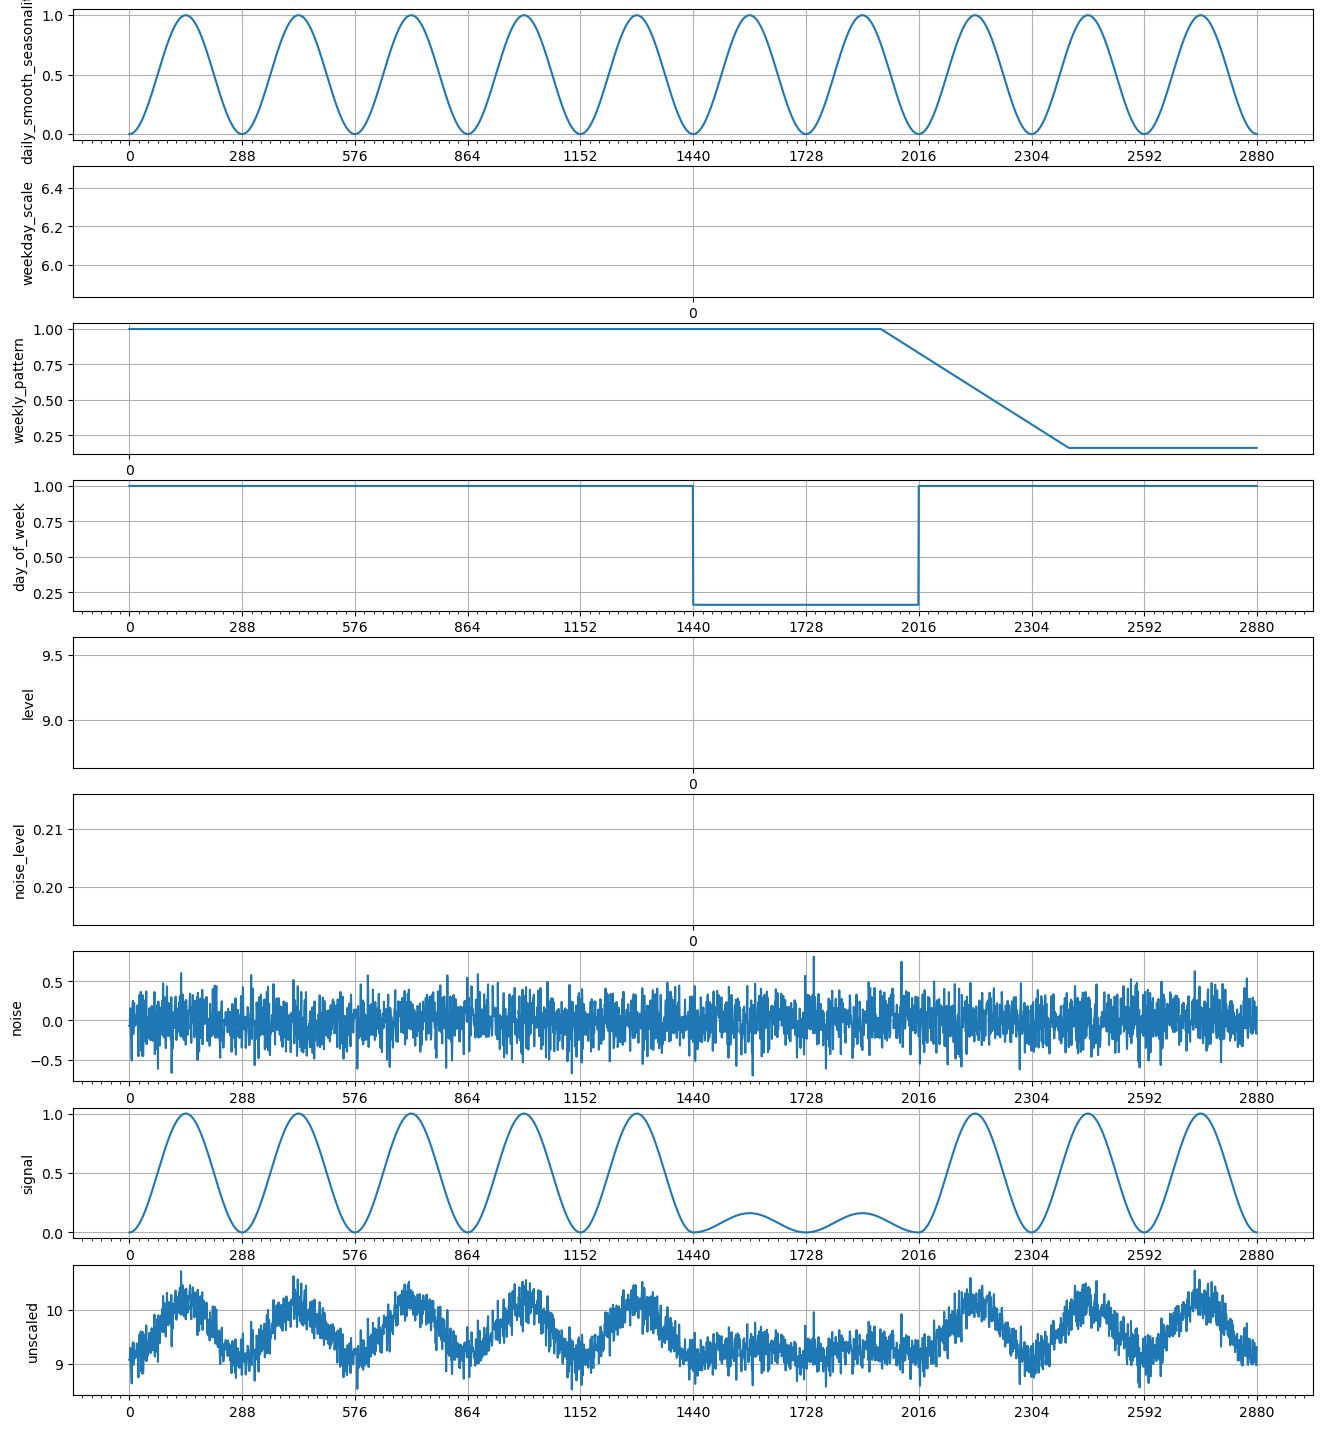

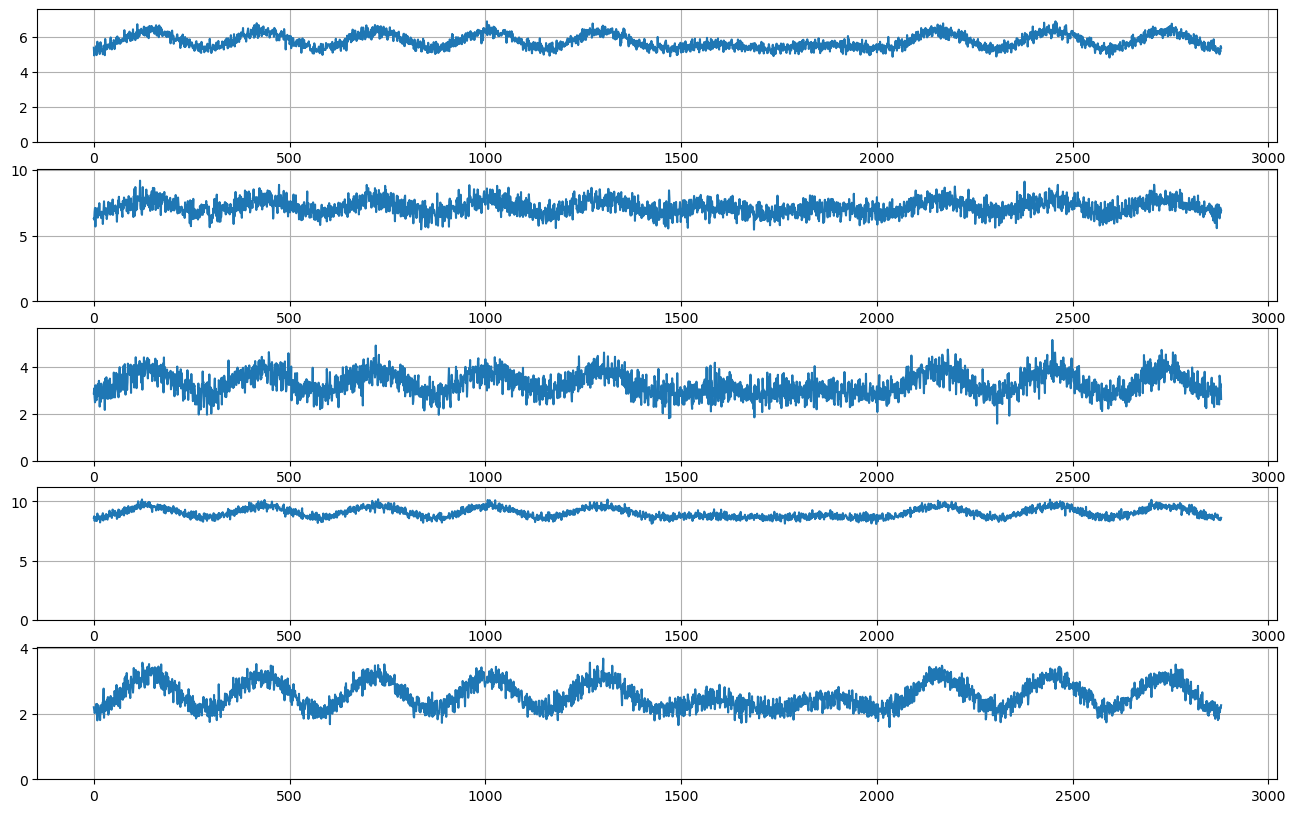

In [6]:
def weekly_seasonal_unscaled():
    daily_smooth_seasonality = rcp.SmoothSeasonality(period=288, phase=-72)
    weekday_scale = rcp.RandomUniform(0.1, 10, shape=(1,))
    weekly_pattern = rcp.NormalizeMax(
        rcp.Concatenate([weekday_scale * np.ones(5), np.ones(2)])
    )
    day_of_week = rcp.Dilated(rcp.Repeated(weekly_pattern), 288)
    level = rcp.RandomUniform(low=0, high=10, shape=1)
    noise_level = rcp.RandomUniform(low=0.01, high=1, shape=1)
    noise = noise_level * rcp.RandomGaussian()
    signal = daily_smooth_seasonality * day_of_week
    unscaled = level + signal + noise

    return dict(
        daily_smooth_seasonality=daily_smooth_seasonality,
        weekday_scale=weekday_scale,
        weekly_pattern=weekly_pattern,
        day_of_week=day_of_week,
        level=level,
        noise_level=noise_level,
        noise=noise,
        signal=signal,
        unscaled=unscaled,
    )


recipe = weekly_seasonal_unscaled()
plot_recipe(recipe, 10 * 288)

plot_examples(recipe["unscaled"], 10 * 288, 5)

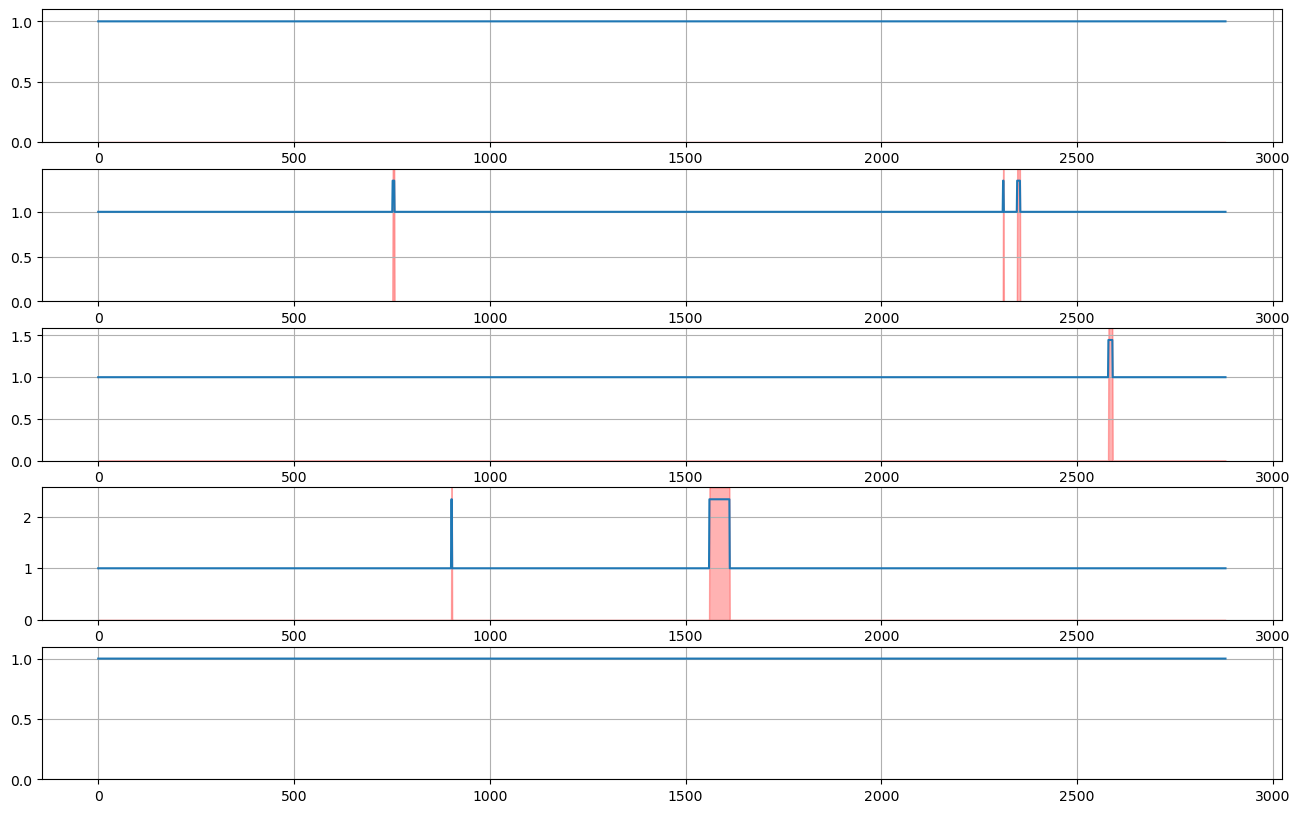

In [7]:
z = rcp.ConstantVec(1.0)


def inject_anomalies(z):
    normal_indicator = rcp.BinaryMarkovChain(one_to_zero=1 / (288 * 7), zero_to_one=0.1)
    anomaly_indicator = 1 - normal_indicator
    anomaly_scale = 0.5 + rcp.RandomUniform(-1.0, 1.0, shape=1)
    anomaly_multiplier = 1 + anomaly_scale * anomaly_indicator
    target = z * anomaly_multiplier
    return target, anomaly_indicator


target, anomaly_indicator = inject_anomalies(z)
plot_examples(target, 10 * 288, 5, anomaly_indicator)

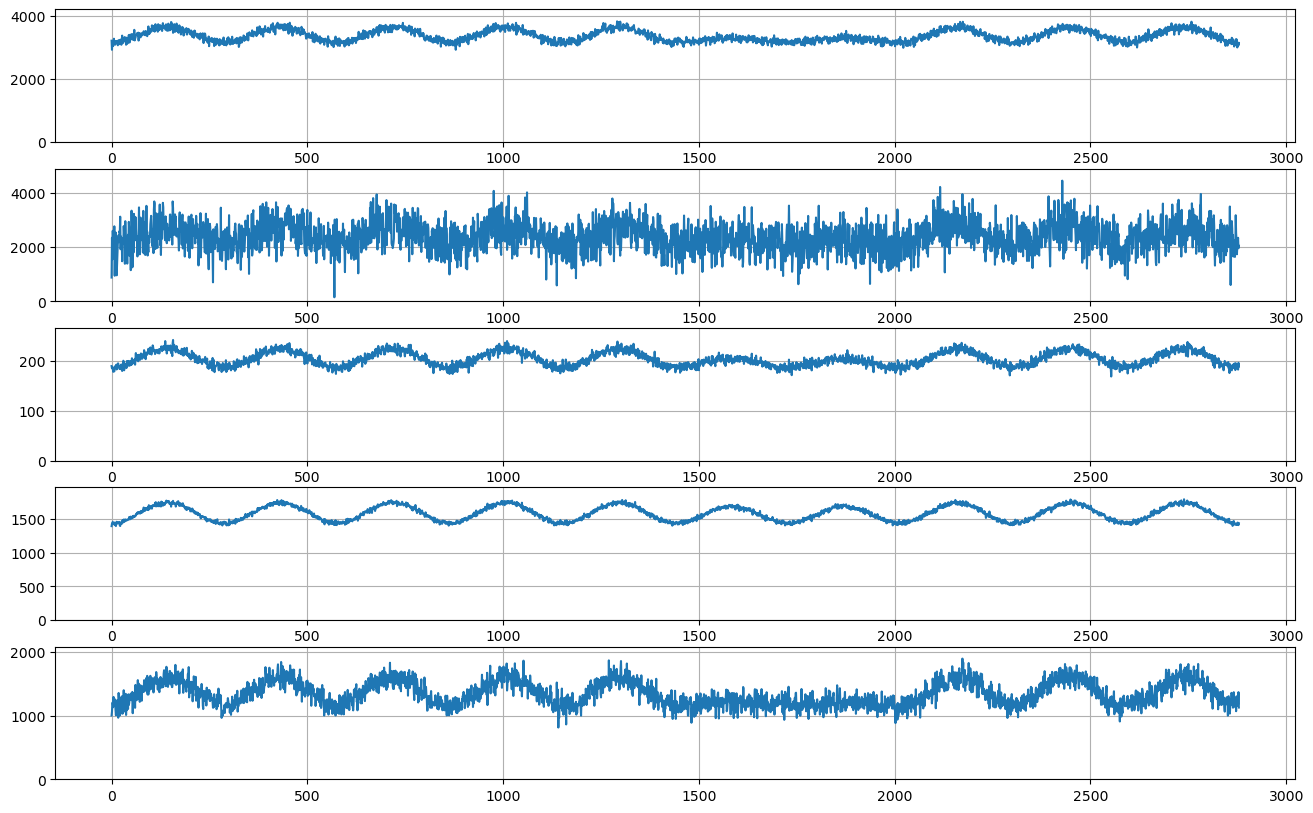

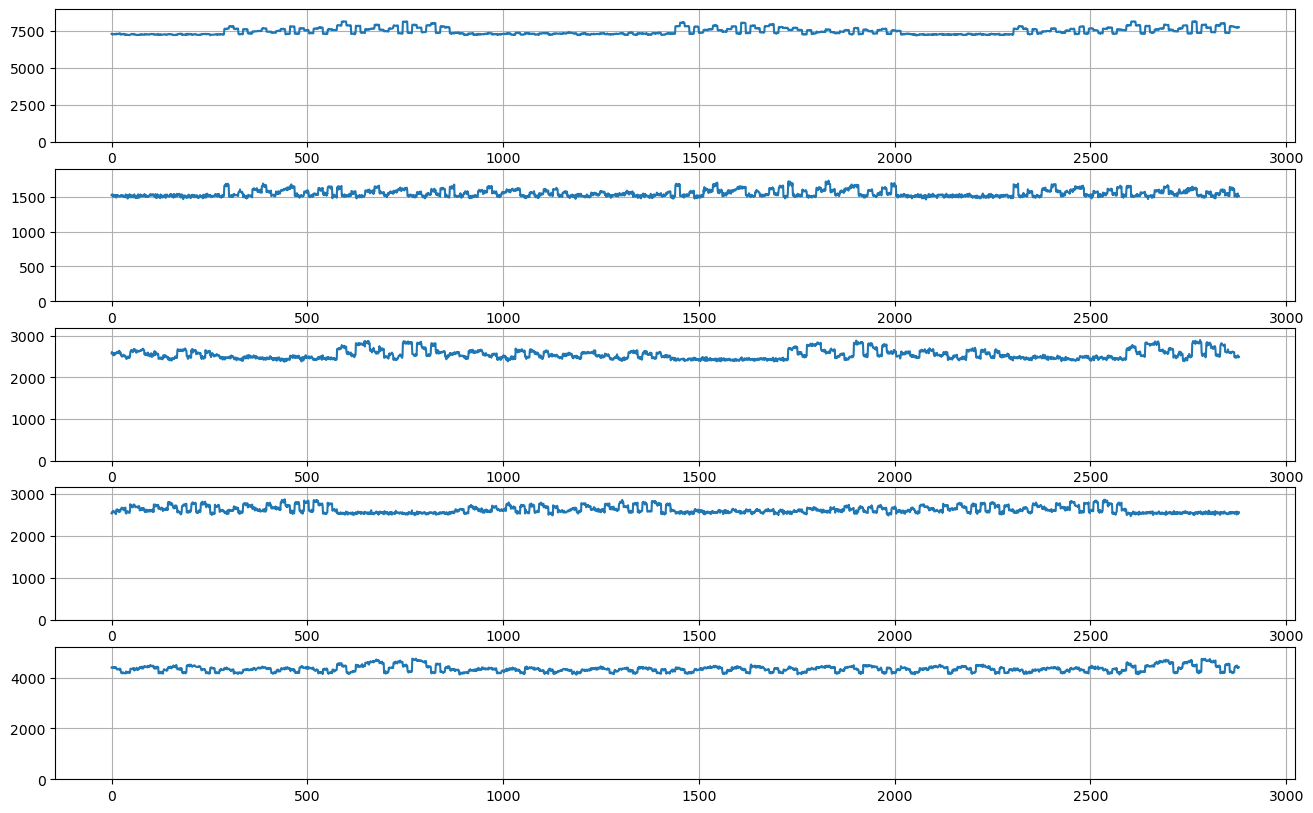

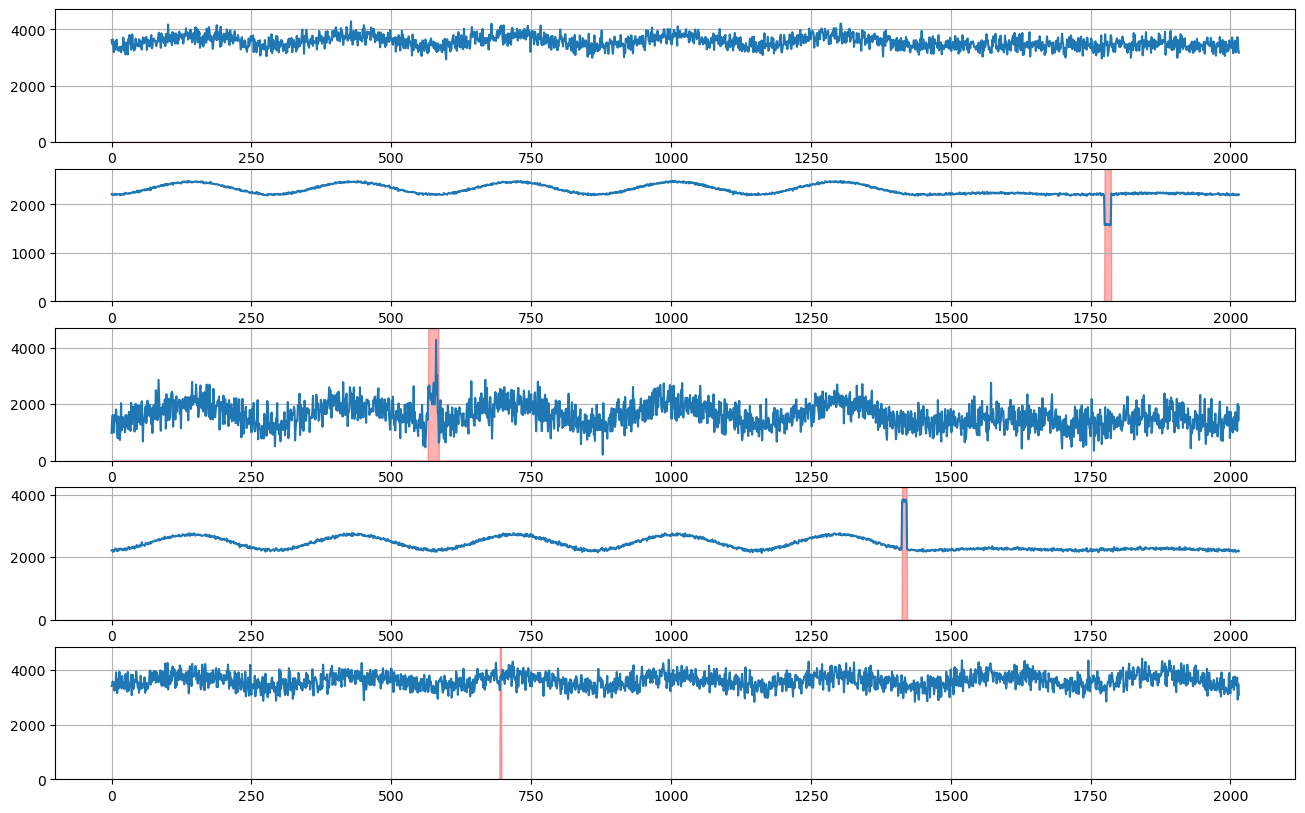

In [8]:
def scale(unscaled):
    s = rcp.RandomUniform(low=0, high=1000, shape=1)
    z = s * unscaled
    return z


def weekly_seasonal():
    c = weekly_seasonal_unscaled()
    unscaled = c["unscaled"]

    scale = rcp.RandomUniform(low=0, high=1000, shape=1)
    z = scale * unscaled
    return z


plot_examples(weekly_seasonal(), 10 * 288, 5)

def complex_weekly_seasonality():
    daily_pattern = rcp.RandomUniform(0, 1, shape=(24,))
    daily_seasonality = rcp.Dilated(rcp.Repeated(daily_pattern), 12)
    weekly_pattern = rcp.RandomUniform(0, 1, shape=(7,))
    weekly_seasonality = rcp.Dilated(rcp.Repeated(weekly_pattern), 288)
    unnormalized_seasonality = daily_seasonality * weekly_seasonality
    seasonality = rcp.NormalizeMax(unnormalized_seasonality)

    noise_level = rcp.RandomUniform(low=0.01, high=0.1, shape=1)
    noise = noise_level * rcp.RandomGaussian()

    level = rcp.RandomUniform(low=0, high=10, shape=1)
    signal = level + seasonality

    unscaled = signal + noise
    return scale(unscaled)


plot_examples(complex_weekly_seasonality(), 10 * 288, 5)
target, anomaly_indicator = inject_anomalies(weekly_seasonal())
plot_examples(target, 288 * 7, 5, anomaly_indicator)

In [12]:
estimator = TradeBotEstimator(
    model_parameters= {
        "rnn_decoder":{
            "dim_hidden_features": 2,
            "num_layers": 2,#32,
            "dim_output": 168, #predict one day ahead for the next week 24*7
        },
    },
    
    num_series = list(train_data)[0]["target"].shape[0],
    input_dim = list(train_data)[0]["target"].shape[1],
    gamma = 1,
    l_norm = 2,
    history_length = history_factor * metadata.prediction_length,
    prediction_length = metadata.prediction_length,
    freq = metadata.freq,
    trainer = Trainer(
        #input_dim = list(train_data)[0]["target"].shape[1],
        # gamma = 0.8,
        # l_norm = 2,
        epochs = 100,
        batch_size = 256,
        num_batches_per_epoch = 512,
        learning_rate = 1e-3,
        weight_decay = 1e-4,
        maximum_learning_rate = 1e-3,
        clip_gradient = 1e3,
        device = torch.device("cpu"),
    ),
    cdf_normalization = False,
    num_parallel_samples = 100,
)